# <span style='background:Yellow'> Bottom Temp & Salt difference between ECCO and WOA

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.29.9:44641")
client

Client Scheduler: tcp://10.32.29.9:44641 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
import geopandas
import scipy
import xesmf as xe

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [88]:
woa8110_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_8110.nc')
woa8110_pt_error = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_error.nc')
woa8110_slt = xr.open_dataset('/home/jovyan/WMT/WOA/san_bottom_wg_8110.nc')
woa8110_slt_error = xr.open_dataset('/home/jovyan/WMT/WOA/san_bottom_error.nc')

woa0517_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_0517.nc')
woa0517_pt_error = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_0517_error.nc')
woa0517_slt = xr.open_dataset('/home/jovyan/WMT/WOA/san_bottom_wg_0517.nc')
woa0517_slt_error = xr.open_dataset('/home/jovyan/WMT/WOA/san_bottom_wg_0517_error.nc')

ecco_temp = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/bottom_temp_wg.nc')
ecco_std_temp = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/bottom_std_temp_ecco.nc')
ecco_slt = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/bottom_slt_wg.nc')
ecco_std_slt = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/bottom_std_slt_ecco.nc')

surface_mask = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/surface_mask.nc')

# <span style='background:Pink'> <font color='Red'> Temperature </font>

In [9]:
ecco_temp = ecco_temp.THETA.mean(dim='time')

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto ECCO's grid

In [10]:
regridder = xe.Regridder(woa8110_pt, ecco_temp, method='bilinear')

woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 ... -0.7204 -0.7081 -0.6951
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto ECCO's grid

In [11]:
regridder_8110_error = xe.Regridder(woa8110_pt_error, ecco_temp, method='bilinear')

woa8110_pt_error_new_grid = regridder(woa8110_pt_error)
woa8110_pt_error_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable PT_error as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:   (i: 95, j: 50, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-15
    lon       (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat       (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    PT_error  (time, j, i) float64 0.0 0.0 0.0 0.0 ... 0.2958 0.4598 0.3391
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (1981-2010) </font>

In [ ]:
#checking if nans
print(np.isnan(ecco_temp.sum()))

In [12]:
ecco_woa8110_diff = ecco_temp - woa8110_pt_new_grid.isel(time=0).PT
ecco_woa8110_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63575033,  2.07516944,  1.94412458, ...,  0.25510106,
         0.2433311 ,  0.22895014],
       [ 0.03369812,  0.34266563,  2.02375475, ...,  0.1893589 ,
         0.17839337,  0.16403622],
       [-0.17822455, -0.03236783,  0.22024657, ...,  0.11020843,
         0.0987603 ,  0.0859307 ]])
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 ...
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

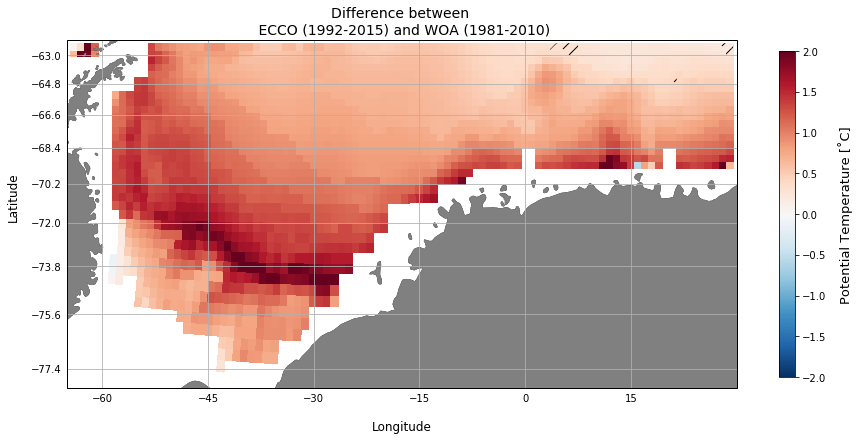

In [106]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa8110_diff.lon, 
                   ecco_woa8110_diff.lat, 
                   ecco_woa8110_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa8110_diff.lon, 
             ecco_woa8110_diff.lat,  
             ecco_woa8110_diff.where(np.abs(ecco_woa8110_diff) < woa8110_pt_error_new_grid.PT_error[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (1981-2010)", fontsize=14);

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp data onto ECCO's grid

In [16]:
regridder_0517 = xe.Regridder(woa0517_pt, ecco_temp, method='bilinear')

woa0517_pt_new_grid = regridder_0517(woa0517_pt)
woa0517_pt_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 ... -0.8279 -0.8171 -0.8026
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp ERROR data onto ECCO's grid

In [17]:
regridder_0517_error = xe.Regridder(woa0517_pt_error, ecco_temp, method='bilinear')

woa0517_pt_error_new_grid = regridder_0517_error(woa0517_pt_error)
woa0517_pt_error_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable PT_error as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:   (i: 95, j: 50, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-15
    lon       (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat       (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    PT_error  (time, j, i) float64 0.0 0.0 0.0 0.0 ... 0.852 0.4471 0.4978
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (2005-2017) </font>

In [18]:
ecco_woa0517_diff = ecco_temp - woa0517_pt_new_grid.isel(time=0).PT
ecco_woa0517_diff

<xarray.DataArray (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.88361031, 2.24873682, 2.07543391, ..., 0.35274895, 0.3460978 ,
        0.33264542],
       [0.29412797, 0.52133069, 2.14992165, ..., 0.29290499, 0.28415616,
        0.27041006],
       [0.09586968, 0.16637828, 0.37163759, ..., 0.21770693, 0.20767789,
        0.19349591]])
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 ...
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

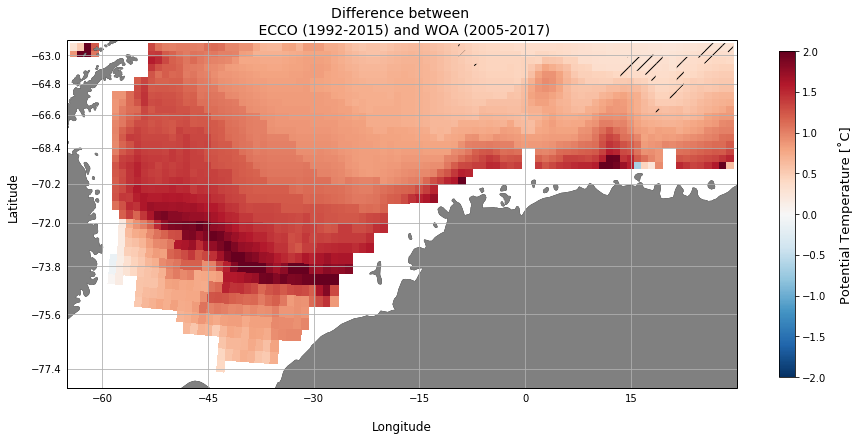

In [105]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa0517_diff.lon, 
                   ecco_woa0517_diff.lat, 
                   ecco_woa0517_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa0517_diff.lon, 
             ecco_woa0517_diff.lat,  
             ecco_woa0517_diff.where(np.abs(ecco_woa0517_diff) < woa0517_pt_error_new_grid.PT_error[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (2005-2017)", fontsize=14);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

In [20]:
ecco_slt = ecco_slt.SALT.mean(dim='time')

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt data onto ECCO's grid

In [21]:
regridder_slt = xe.Regridder(woa8110_slt, ecco_slt, method='bilinear')

woa8110_slt_new_grid = regridder_slt(woa8110_slt)
woa8110_slt_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable san as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    san      (time, j, i) float64 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt ERROR data onto ECCO's grid

In [85]:
regridder_slt_error = xe.Regridder(woa8110_slt_error.sse.fillna(0.), ecco_slt, method='bilinear')

woa8110_slt_error_new_grid = regridder_slt_error(woa8110_slt_error)
woa8110_slt_error_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable sse as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    sse      (time, j, i) float64 0.0 0.0 0.0 ... 0.0001364 0.0002919 0.0002876
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (1981-2010) </font>

In [75]:
#checking if nans
print(np.isnan(ecco_slt.sum()))

<xarray.DataArray 'SALT' ()>
array(False)


In [86]:
ecco_woa8110_slt_diff = ecco_slt - woa8110_slt_new_grid.isel(time=0).san
ecco_woa8110_slt_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00993408, -0.03452171, -0.02911726, ...,  0.01802321,
         0.01728204,  0.01816683],
       [ 0.00202797,  0.01102082, -0.0302459 , ...,  0.01825414,
         0.01759584,  0.01849445],
       [ 0.0030096 ,  0.00996992, -0.00306433, ...,  0.01887711,
         0.01834079,  0.01863853]])
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 ...
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

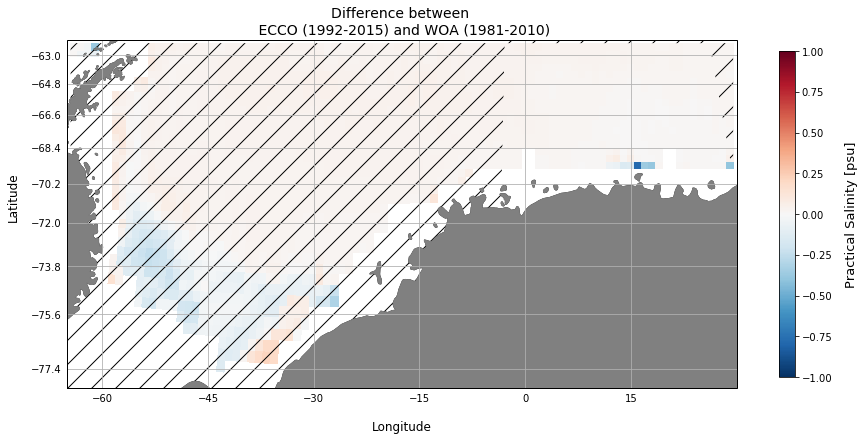

In [103]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
im = ax.pcolormesh(ecco_woa8110_slt_diff.lon, 
                   ecco_woa8110_slt_diff.lat, 
                   ecco_woa8110_slt_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa8110_slt_diff.lon, 
             ecco_woa8110_slt_diff.lat, 
             ecco_woa8110_slt_diff.where(np.abs(ecco_woa8110_slt_diff) < woa8110_slt_error_new_grid.sse[0]).where(surface_mask.hFacC).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (1981-2010)", fontsize=14);

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt data onto ECCO's grid

In [26]:
regridder_0517_slt = xe.Regridder(woa0517_slt, ecco_slt, method='bilinear')

woa0517_slt_new_grid = regridder_0517_slt(woa0517_slt)
woa0517_slt_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable san as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    san      (time, j, i) float64 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt ERROR data onto ECCO's grid

In [27]:
regridder_0517_slt_error = xe.Regridder(woa0517_slt_error, ecco_slt, method='bilinear')

woa0517_slt_error_new_grid = regridder_0517_slt_error(woa0517_slt_error)
woa0517_slt_error_new_grid

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable sse as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    sse      (time, j, i) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0001441 0.0 nan nan
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (2005-2017) </font>

In [28]:
ecco_woa0517_slt_diff = ecco_slt - woa0517_slt_new_grid.isel(time=0).san
ecco_woa0517_slt_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01148396, -0.04678645, -0.04484199, ...,  0.01805283,
         0.0174104 ,  0.01828598],
       [ 0.00318212,  0.00828429, -0.03334651, ...,  0.01834517,
         0.0177583 ,  0.01872619],
       [ 0.00382041,  0.01115073, -0.00197213, ...,  0.01898723,
         0.01849464,  0.01894238]])
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 ...
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

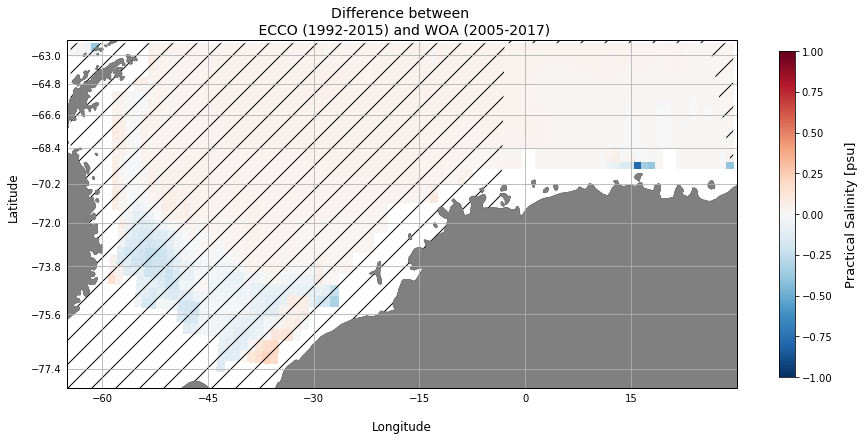

In [102]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa0517_slt_diff.lon, 
                   ecco_woa0517_slt_diff.lat, 
                   ecco_woa0517_slt_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa0517_slt_diff.lon, 
             ecco_woa0517_slt_diff.lat, 
             ecco_woa0517_slt_diff.where(np.abs(ecco_woa0517_slt_diff) < woa0517_slt_error_new_grid.sse[0]).where(surface_mask.hFacC).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (2005-2017)", fontsize=14);